In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

In [ ]:
# user set algo params
in_size_threshold = 250 # 500 750 250
in_kernel_size = 7 # 5 7 3
in_remove_boundary_objects = False # True False

In [ ]:
# load lab 4 images
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Dataset_BUSI_with_GT/setImages')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
benign = plt.imread('Copy of benign (1).png')
benign_mask = plt.imread('Copy of benign (1)_mask.png')
malignant = plt.imread('Copy of malignant (1).png')
malignant_mask = plt.imread('Copy of malignant (1)_mask.png')
normal = plt.imread('Copy of normal (1).png')
normal_mask = plt.imread('Copy of normal (1)_mask.png')

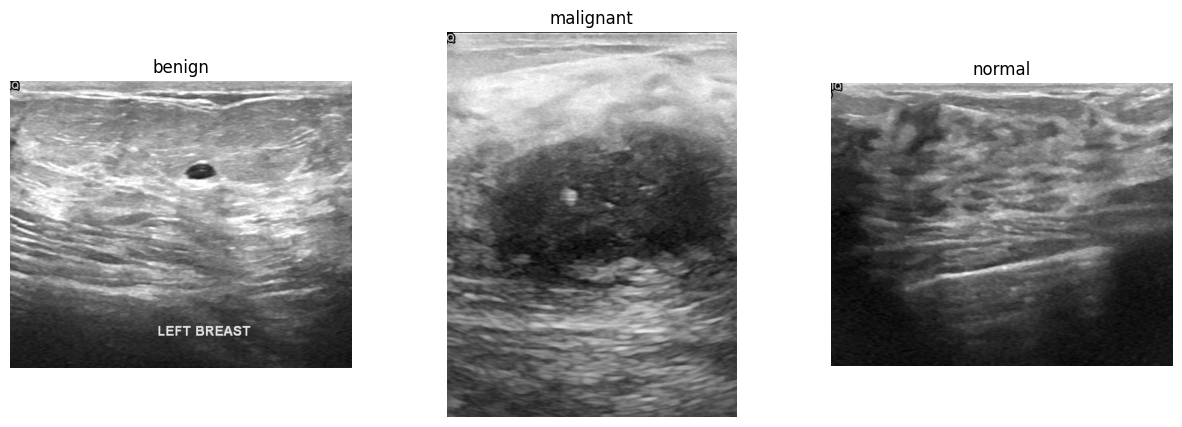

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('benign')
plt.imshow(benign)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('malignant')
plt.imshow(malignant)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('normal')
plt.imshow(normal)
plt.axis('off')

plt.show()

> Write an algorithm that performs image segmentation and subsequent
analysis using just intensity thresholding and binary morphological operators.


More specifically, the algorithm should be able to take any of the given lab images, produce a segmentation result containing only the bigger objects that are completely contained in the image, and print the number of objects

> Hints: Convert the input image to grayscale, apply intensity thresholding (using either a single threshold or multiple to segment out intensities within a range), use binary morphology operators to fill any holes and filter out noise pixels in the segmentation, use binary reconstruction and subtraction to get rid of segmented objects touching the image boundary, set the remaining objects that are smaller than some size threshold to black, and then count and print the final number of objects.

# v4

In [ ]:
def calculate_iou(pred_mask, true_mask):
    # Ensure both masks are binary (0 and 1) and single-channel
    if len(true_mask.shape) == 3:
        true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2GRAY)

    # Convert to binary (0 or 1) for logical operations
    pred_mask = (pred_mask > 0).astype(bool)
    true_mask = (true_mask > 0).astype(bool)

    # Compute intersection and union
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()

    # Avoid division by zero
    if union == 0:
        return 0.0

    # Calculate IoU
    iou = intersection / union
    return iou

In [ ]:
def segment_and_count_objects_v4(img, true_mask, size_threshold=in_size_threshold, kernel_size=in_kernel_size, remove_boundary_objects=in_remove_boundary_objects):
    # grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # to 8-bit unsigned integer
    gray_8bit = cv2.convertScaleAbs(gray)
    # Otsu thresholding
    _, binary_img = cv2.threshold(gray_8bit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # remove noise and fill holes
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    cleaned_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    # remove objects touching the image boundary
    if remove_boundary_objects:
        contours, _ = cv2.findContours(cleaned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        height, width = cleaned_img.shape
        for contour in contours:
            for point in contour:
                if point[0][0] == 0 or point[0][1] == 0 or point[0][0] == width - 1 or point[0][1] == height - 1:
                    cv2.drawContours(cleaned_img, [contour], -1, 0, -1)
    # remove smaller objects
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned_img)
    for i in range(1, num_labels):  # skip background label
        if stats[i, cv2.CC_STAT_AREA] < size_threshold:
            cleaned_img[labels == i] = 0

    iou_score = calculate_iou(cleaned_img, true_mask)
    # count remaining
    final_num_labels, _, _, _ = cv2.connectedComponentsWithStats(cleaned_img)
    num_objects = final_num_labels # - 1
    return cleaned_img, num_objects, iou_score

In [ ]:
final_benign, nlab_benign, iou_benign = segment_and_count_objects_v4(benign, benign_mask)
final_malignant, nlab_malignant, iou_malignant = segment_and_count_objects_v4(malignant, malignant_mask)
final_normal, nlab_normal, iou_normal = segment_and_count_objects_v4(normal, normal_mask)

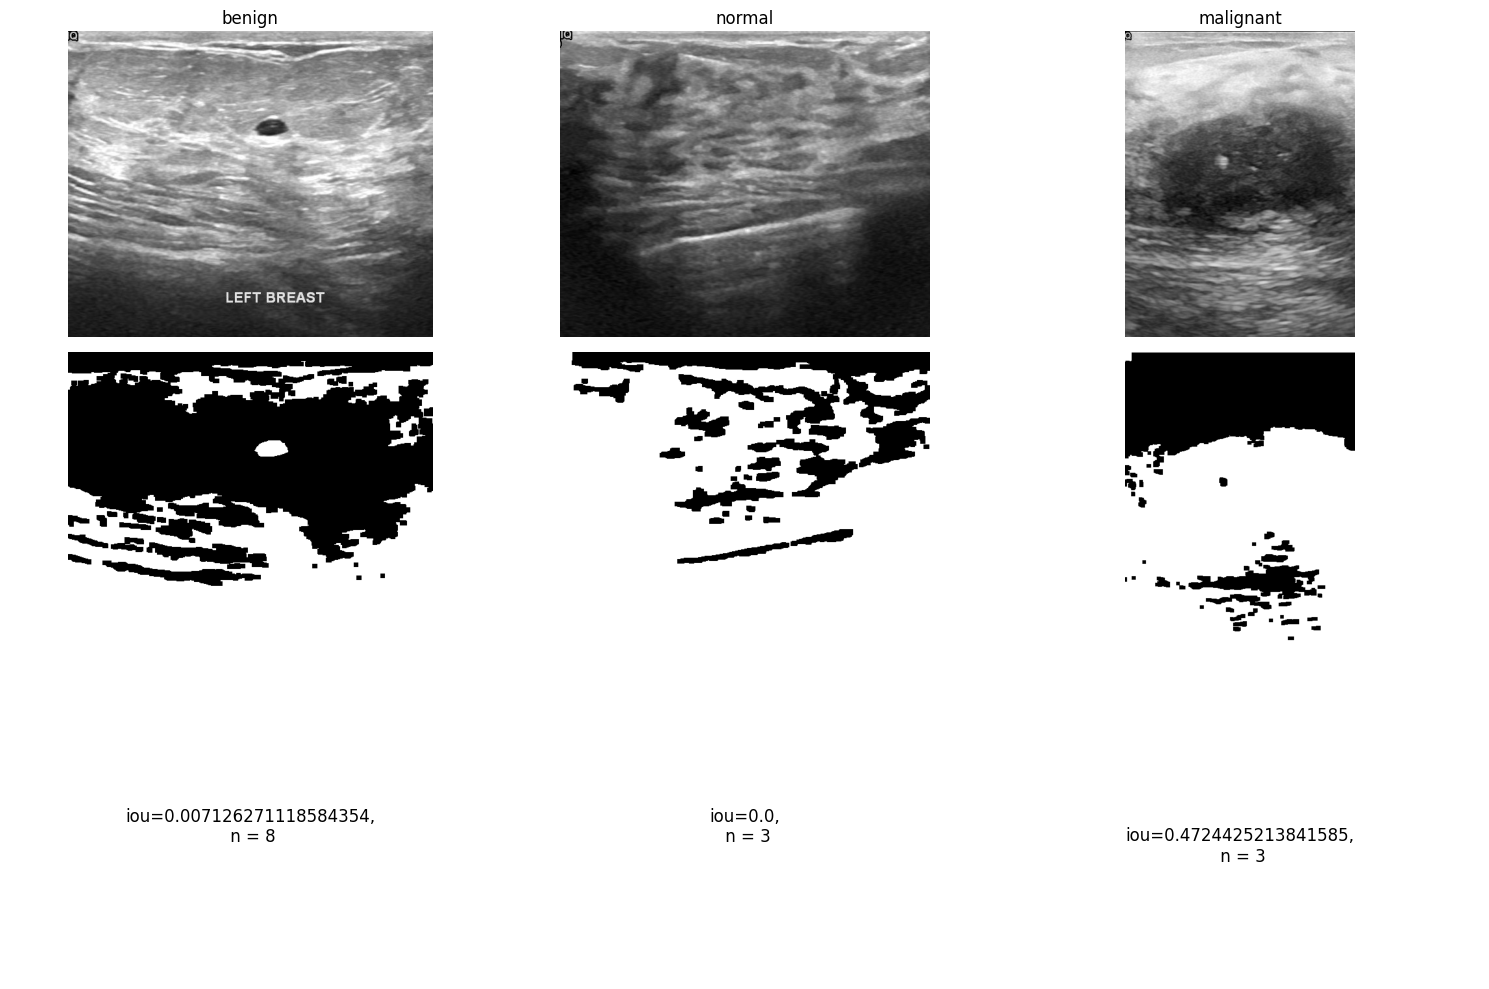

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

axs[0, 0].imshow(benign)
axs[0, 0].axis('off')
axs[0, 0].set_title('benign')
axs[1, 0].imshow(final_benign, cmap='gray')
axs[1, 0].axis('off')
axs[2, 0].axis('off')
axs[2, 0].text(0.5, 0.5, f'iou={iou_benign},\n n = {nlab_benign}', horizontalalignment='center', verticalalignment='center', fontsize=12)

axs[0, 2].imshow(malignant)
axs[0, 2].axis('off')
axs[0, 2].set_title('malignant')
axs[1, 2].imshow(final_malignant, cmap='gray')
axs[1, 2].axis('off')
axs[2, 2].axis('off')
axs[2, 2].text(0.5, 0.5, f'iou={iou_malignant},\n n = {nlab_malignant}', horizontalalignment='center', verticalalignment='top', fontsize=12)

axs[0, 1].imshow(normal)
axs[0, 1].axis('off')
axs[0, 1].set_title('normal')
axs[1, 1].imshow(final_normal, cmap='gray')
axs[1, 1].axis('off')
axs[2, 1].axis('off')
axs[2, 1].text(0.5, 0.5, f'iou={iou_normal},\n n = {nlab_normal}', horizontalalignment='center', verticalalignment='center', fontsize=12)


plt.tight_layout()
plt.show()

# end